In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
from sklearn.metrics import calinski_harabaz_score

In [2]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata("MNIST original")
images = mnist.data / 255.0
target = mnist.target

In [3]:
print(images.shape)

(70000, 784)


# Dimensionality Reduction - PCA

Since this problem of image classification deals with high dimensionality (784 dimensions for each image), I can use PCA to reduce the dimensionality of each image without loosing critical information that is helpful in the classification process. This helps me overcome the curse of dimensionality problem that with really high dimensions, data points have a great chance of being far away from each other than in lower dimensions. Reducing the dimensions also helps me with the problem of overfitting. One of the drawbacks of PCA is that it assumes the components are linear combinations of the original features. Depending on the data that we have, that might not be the case.

What PCA is doing is projecting the entire dataset with all 784 features onto the axes of a hyperplane that maximize the variance, so that the least amount of information is lost. The Explained Variance graph shows the relationship that as you increase the number of components used in the projection, the variance captured increases. Less information is lost from the original features as you increase the number of components.

Text(0.5,1,'Explained Variance')

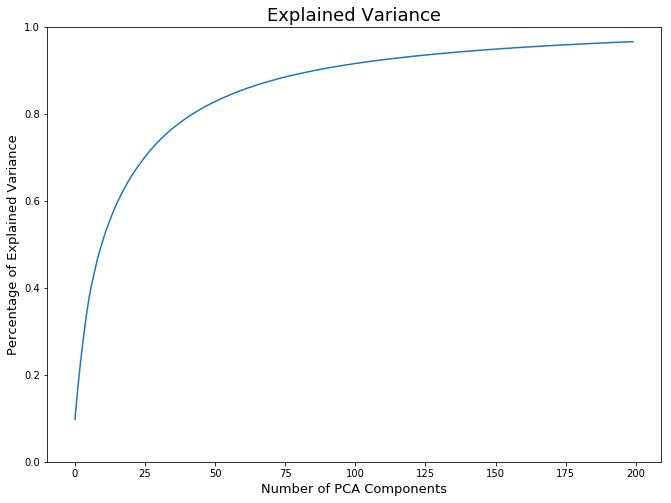

In [21]:
pca = PCA(n_components = 200)
images_pca = pca.fit_transform(images)
cum_ratio = np.cumsum(pca.explained_variance_ratio_)

fig, ax = plt.subplots(figsize = (11,8))
plt.plot(range(len(cum_ratio)), cum_ratio)
plt.xlabel('Number of PCA Components', fontsize = 13)
plt.ylabel('Percentage of Explained Variance', fontsize = 13)
plt.ylim(0,1)
plt.title('Explained Variance', fontsize = 18)

In [22]:
pca = PCA(n_components = 0.95)
images_pca = pca.fit_transform(images)
print(images_pca.shape)

(70000, 154)


Based on the graph, about 75 PCA components explain about 85 percent of the variance within the data. Since the standard rule is use the number of components that explain 95 percent of the variance, I use 154 PCA components.

In [3]:
images_scaled = images - images.mean()
pca2 = PCA(n_components = 2) # can use this instead of doing singular value decomposition
X2D = pca2.fit_transform(images)

In [24]:
#Extracting first two columns to get 1st and 2nd components
component1 = pca2.components_.T[:,0]
component2 = pca2.components_.T[:,1]

Text(0.5,1,'1st Component')

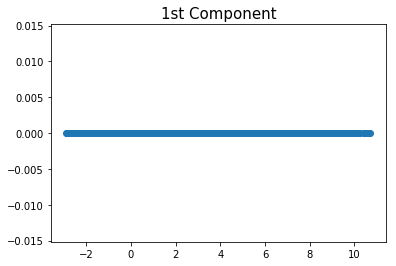

In [42]:
proj_1 = images_scaled.dot(component1)
plt.scatter(proj_1, np.zeros(len(proj_1)))
plt.title('1st Component', fontsize = 15)

Text(0.5,1,'2nd Component')

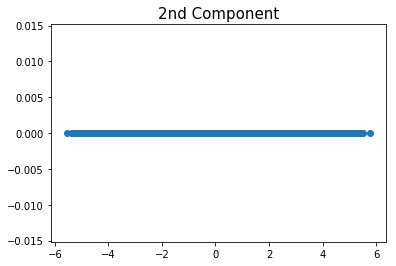

In [43]:
proj_2 = images_scaled.dot(component2)
plt.scatter(proj_2, np.zeros(len(proj_2)))
plt.title('2nd Component', fontsize = 15)

These two graphs show the projection of the entire dataset onto the first and second PCA components. The first and second components are orthogonal to each other. The length that is seen in the respective graphs represent the variance of each component. The first component is slightly longer than the second component. The first PCA component maximizes the variance, then subsequent components have less variance and would be shorter.

In [33]:
def Display_Images(row, num_components):
    plt.figure(figsize = (8,6))
    plt.subplot(1, 2, 1)
    plt.imshow(images[row].reshape((28,28)), cmap = 'Greys')
    plt.title('Original Image', fontsize = 16)
    plt.axis('off')
    
    pca = PCA(n_components = num_components)
    image_pca = pca.fit_transform(images)
    reverse = pca.inverse_transform(image_pca)
    
    plt.subplot(1, 2, 2)
    plt.imshow(reverse[row].reshape((28,28)), cmap = 'Greys')
    plt.title('Compressed Image', fontsize = 16)
    plt.axis('off')

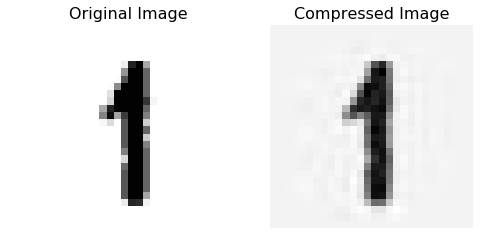

In [34]:
Display_Images(11000, 154)

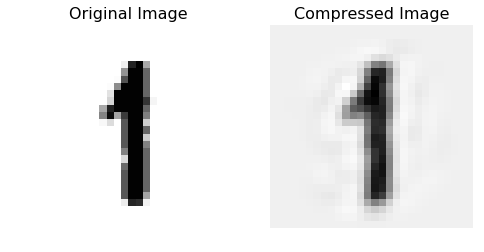

In [35]:
Display_Images(11000, 50)

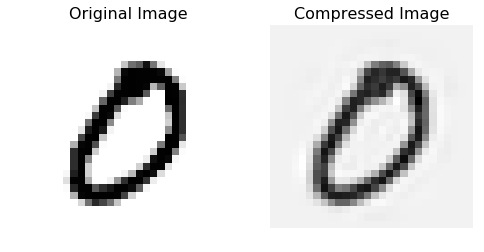

In [36]:
Display_Images(250, 154)

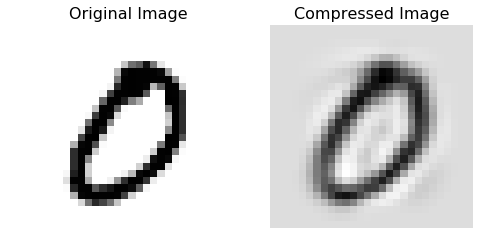

In [37]:
Display_Images(250, 50)

In some of these images I compress the original with all of its features onto 154 PCA components. The compressed images are not as sharp, but they are still very close to the original. When I decrease even more the number of PCA components down to 50, the image becomes even more blurry. However even with 50 components, which still explains roughly 80 percent of the variance, the numbers are still discernible.

# T-SNE

In [12]:
def Plot_TSNE(perp, l_rate, iterations):
    pca = PCA(n_components = 50)
    pca_images = pca.fit_transform(images)
    
    rows = np.arange(70000)
    np.random.shuffle(rows)
    n_select = 10000
    
    tsne = TSNE(n_components = 2, perplexity = perp, n_iter = iterations, learning_rate = l_rate)
    tsne_results = tsne.fit_transform(pca_images[rows[:n_select],:])
    
    df_tsne = pd.DataFrame(tsne_results, columns = ['comp1', 'comp2'])
    df_tsne['label'] = target[rows[:n_select]]
    
    sns.lmplot(x = 'comp1', y = 'comp2', data = df_tsne, hue = 'label', fit_reg = False)   

The following t-SNE plots are different than the PCA plots since since t-SNE is used more for visualization of higher dimensional data in two dimensions. I used PCA with 50 components and then used t-SNE to visualize those 50 dimensions in two dimensions. The t-SNE algorithm maintains the proximity of data points in higher dimensions when down in lower dimensions. This is different than the PCA plots where I project the dataset onto the principal components that maximize variance.

### Changing Perplexity

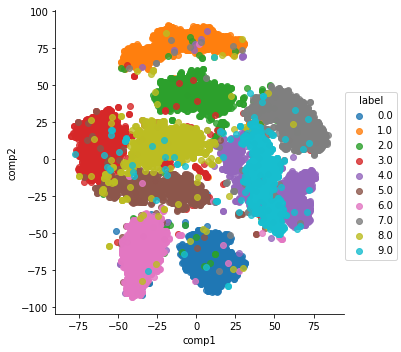

In [13]:
Plot_TSNE(30, 300, 1000)

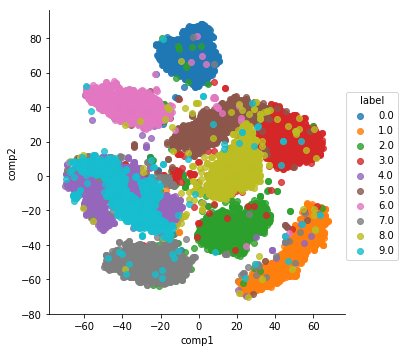

In [14]:
Plot_TSNE(50, 300, 1000)

According to van der Maaten and Hinton, the ones who first introduced t-SNE, t-SNE is very robust to changes in perplexity, which is one of the main hyperparameters, when the perplexity is between 5 and 50. This can be seen on the two previous graphs, despite the increase in perplexity. Perplexity, which balances the local and global aspects of the data, did not have a large affect on the graph. Once outside of the range of 5 and 50, changes in perplexity can really disrupt the balance as previously described.

### Learning Rate and Number of Iterations

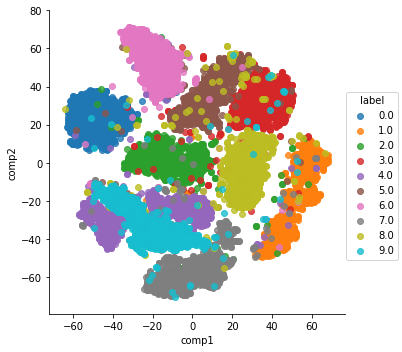

In [15]:
Plot_TSNE(30, 100, 1000)

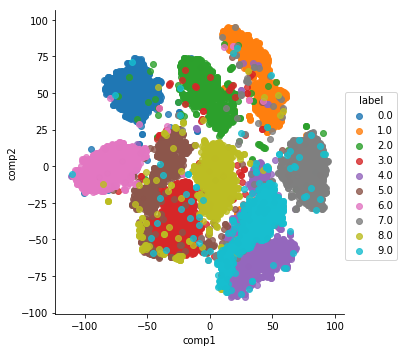

In [16]:
Plot_TSNE(30, 900, 1000)

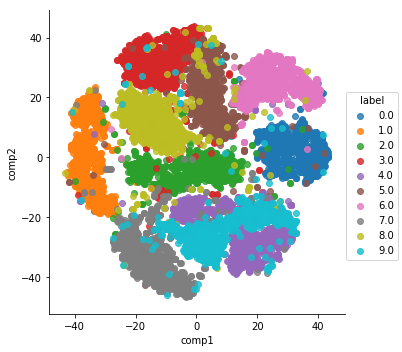

In [17]:
Plot_TSNE(30, 900, 400)

Learning rate and the number of iterations are other hyperparameters of t-SNE and they help determine when you reach a stable configuration. The three previous plots have different combinations of these parameters. Each appears to have reached a stable configuration. However, it does appear that the second graph with a higher learning rate, seems to be a little bit more stable than the first with a smaller learning rate. But, it appears that our t-SNE plots are fairly robust to changes in learning rate and the number of iterations.

# K-Means Clustering

When choosing K, the hyperparameter for the number of clusters using this method, I choose 10 since I am trying to classify images that are between 0 and 9. 

In [5]:
def KMEANS_TSNE(df, perp):
    pca = PCA(n_components = 50)
    X_pca = pca.fit_transform(df)
    kmeans_model = KMeans(n_clusters= 10, n_init = 50, n_jobs = -1).fit(X_pca)
    labels = kmeans_model.labels_
    k_clusters = kmeans_model.predict(X_pca)
    score = round(calinski_harabaz_score(images, labels), 3)
    print('The Calinski-Harabaz Index is {}'.format(score))
    
    rows = np.arange(70000)
    np.random.shuffle(rows)
    n_select = 10000
    
    tsne = TSNE(n_components = 2, perplexity = perp, n_iter = 1000, learning_rate = 300)
    tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])
    
    df_tsne = pd.DataFrame(tsne_results, columns = ['comp1', 'comp2'])
    df_tsne['label'] = k_clusters[rows[:n_select]]
    
    sns.lmplot(x = 'comp1', y = 'comp2', data = df_tsne, hue = 'label', fit_reg = False)

The Calinski-Harabaz Index is 2687.48


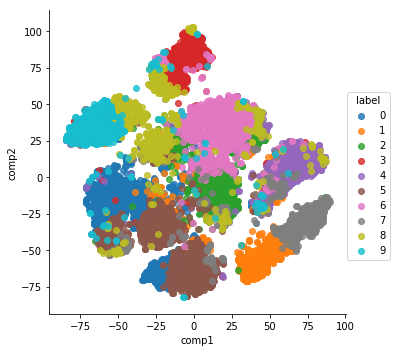

In [25]:
KMEANS_TSNE(images, 30)

For my evaluation method, I choose to use the Calinski-Harabaz Index. This number is given as the ratio of the between-clusters dispersion mean and the within-cluster dispersion mean. A higher number is a indicator that the clusters are very dense and well separated. This metric is helpful when the true labels are not known, which is generally the case with unsupervised learning. The silhouette coefficient is another metric that can be helpful when the labels are not known. There are other metrics that can be used if the labels are known, which is applicable with this dataset since the true labels of each image are known, such as the Adjusted Rand Index and Fowlkes-Mallows index.

The Calinski-Harabaz Index is 2687.472


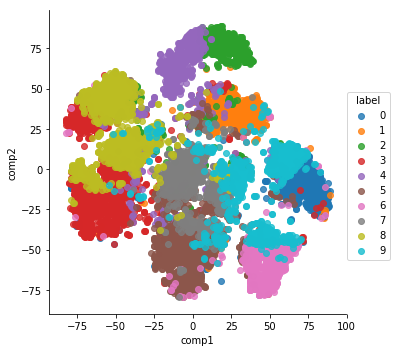

In [6]:
KMEANS_TSNE(images_scaled, 30)

With the previous plot, I tried scaling my data by subtracting the mean from each column. It looks like I got similar Calinski-Harabaz Indexes, so the scaling did not have a large effect on the clustering. With this scaling, it looks like I didn't loose valuable information from the data, which can happen when you scale in higher dimensions. Also, since I use a new random sample and got similar evaluation scores even with the scaled data, it appears that my clustering is fairly robust.

# Hierarchical Clustering

In [48]:
def Dendrogram_Plot(method):
    images_shuffled = shuffle(images, random_state = 42) #to get a random sample of all my images
    hierarchy = linkage(images_shuffled[0:90], method) #take the first 90 images after the shuffle
    plt.figure(figsize = (15,10))
    _ = dendrogram(hierarchy)

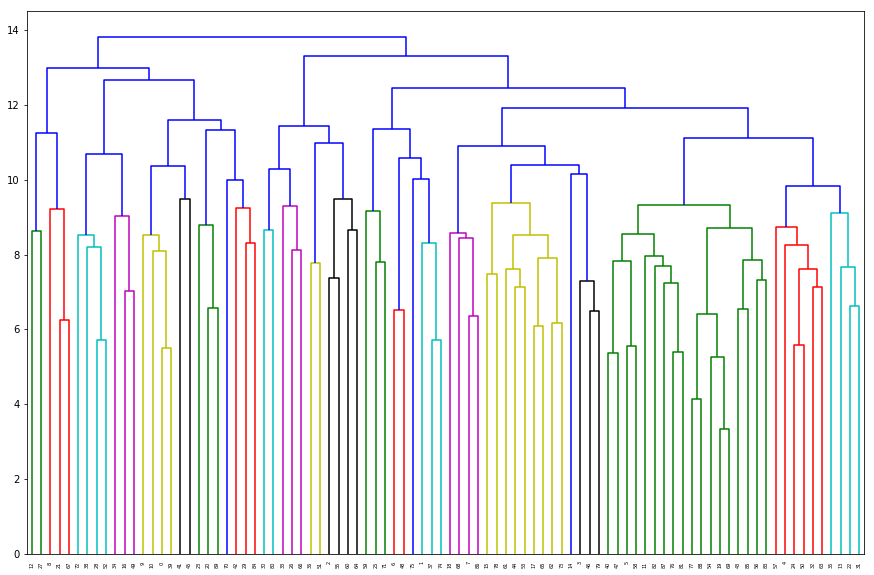

In [49]:
Dendrogram_Plot('complete')

Based on this dendrogram, the number of clusters that seems reasonable from this random sample of 90 images is drawing a straingt horizontal line from a number on the vertical axis and seeing how many vertical lines it crosses. For me, it seems reasonable to choose 11 on the vertical axis. With that, I can make 13 clusters. 

### Linkage Methods

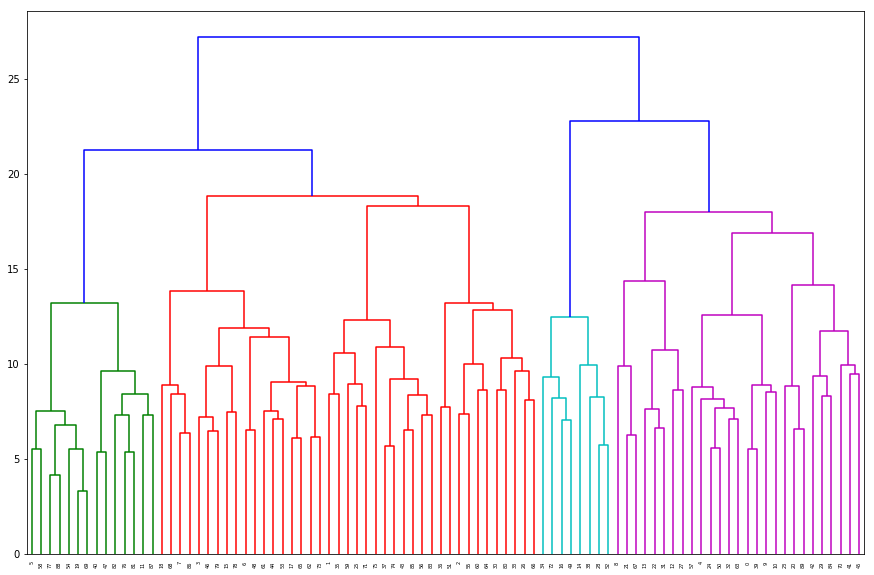

In [40]:
Dendrogram_Plot('ward')

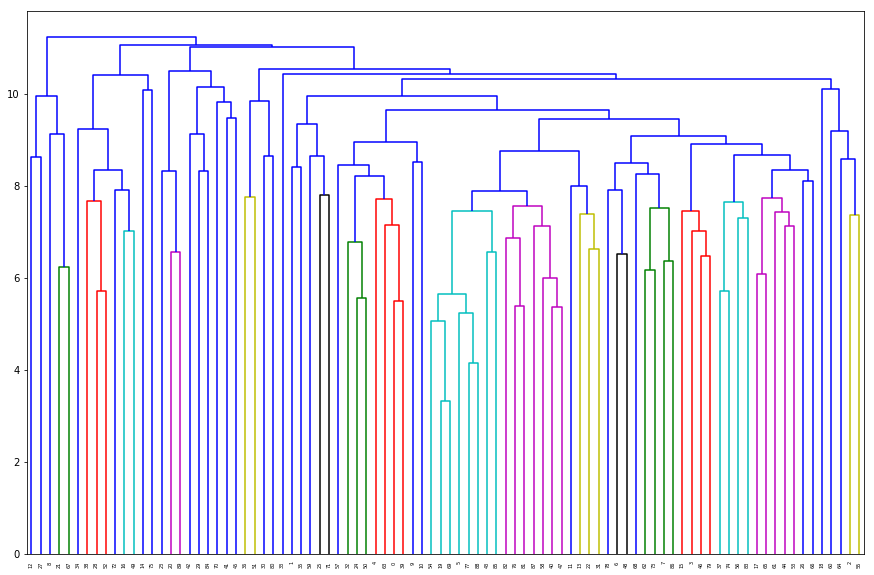

In [41]:
Dendrogram_Plot('average')

In this section I use different linkage methods for this example of agglomerative clustering. Linkage methods determine the distance between clusters in order to decide when clusters are deemed close enough to be merged. I used a ward method, which merges two clusters to minimize the variance within a newly formed cluster, and an average method, which measures the average distance between points in a cluster. These two linkage methods produce dendrograms that are significantly different than the first dendrogram. If I choose 11 again on the vertical axis, 24 clusters would be formed using the ward method and only two clusters with the average method. With the ward method, it seems more reasonable to use 7 clusters by placing the line at 17 on the vertical axis. 